# Convolutional Neural Networks

#### Theory of Convolutions 

In Machine Learning "Convolution" usally refers to the use of Convolutions in Convolutional Layers of Convolutional Neural Networks (CNN's). 
In that case, the Convolution is always discrete, but the term comes from the Convolution of two functions $f,g$ as follow: 
$$
    (f * g)(x) = \int_{-\infty}^\infty f(y)g(x-y) dy
$$
Which has many applications, before coming across the one in Image processing and Machine Learning for Vision I mostly knew Convolutions from Probabilty Theory and Fourier Analysis. 
See https://en.wikipedia.org/wiki/Convolution for a decent overview of all its applications! 

Convolutions for Images is well explained on the Huggingface course page: https://huggingface.co/learn/computer-vision-course/unit2/cnns/introduction. 

For me it was very rewarding to think about how the continuous convolution and the one used in Machine Learning relate to each other! 

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from keras import layers
import cv2

#### Visualizing Convolutions 

<function matplotlib.pyplot.show(close=None, block=None)>

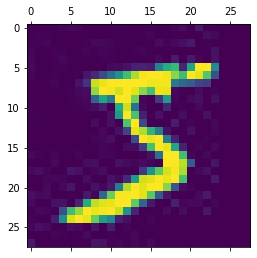

In [31]:
#load any image to look how convolutions/pooling affects the image
img = cv2.imread("handwritten.jpg")
#reduce to 1 stream 
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Resize to 28x28 pixels
img = cv2.resize(img, (28, 28))  
# Convert the image to a NumPy array
img = np.array(img)
# Normalize the matrix values to the range [0, 1], if needed
img = img / 255.0


### For looking at convolutions in more detail, we shall use this dummyimage 

dummyimg = np.array([[0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0],
               [0,0,1,1,1,1,0,0],
               [0,0,1,2,2,1,0,0], 
               [0,0,1,2,2,1,0,0], 
               [0,0,1,1,1,1,0,0], 
               [0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0]])

images = [dummyimg, img]

plt.matshow(img)
plt.show

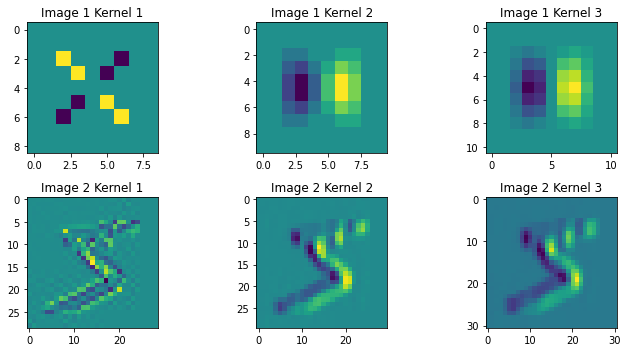

In [42]:
from scipy.signal import convolve2d


#defining some Kernels
kernel1 = np.array([[1/2, -1/2],
                   [-1/2, 1/2]])
kernel2 = np.array([[-1,0,1],
                    [-1,0,1],
                    [-1,0,1]])

kernel3 = np.array([[-1,-1,1,1],
                    [-1,-1,1,1],
                    [-1,-1,1,1], 
                    [-1,-1,1,1]])

k = [kernel1, kernel2, kernel3]


def show_Convolutions(images, kernels):
    convImg = []

    #Generate Convolutions
    for i in range(len(images)):
        for j in range(len(kernels)):
            convImg.append(convolve2d(images[i], kernels[j], fillvalue = 0))

    #setting up plotting
    _ , axes = plt.subplots(len(images), len(kernels), figsize=(10, 5))
    axes = axes.flatten()

    # Plot the Convoluted Images
    for i in range(len(convImg)):
        axes[i].imshow(convImg[i])
        axes[i].set_title(f'Image {(i//len(kernels))+1} Kernel {(i % len(kernels))+1}')

    # Show the plots
    plt.tight_layout()
    plt.show()

show_Convolutions(images, k)


#### Classic Pooling

For Feature Extraction we generally dont care where the exact features are located in the image, which is why Pooling is useful in that case. There we take a patch of an Image (often 2x2 or 3x3 Pixels, similar to classic sizes for Kernels) and just take some operation on that patch as the new Value (Max, Min, Average etc.) thus downsizing the image! 

There also is global Pooling, which, as the name says, does not utilize some patch but instead reduces the image down to a single number, where we can again use something like min, max or the average. This is usally used to reduce the amount of Feature maps we have down to some vectors which then might be used for classification etc.

Now let's visualize what Pooling does to Images/Matricies!

In [44]:
from skimage.measure import block_reduce

#writing our Pooling functions for easy use
def max_pooling(matrix, pool_size):
    return block_reduce(matrix, block_size=(pool_size, pool_size), func=np.max)

def min_pooling(matrix, pool_size):
    return block_reduce(matrix, block_size=(pool_size, pool_size), func=np.min)

def avg_pooling(matrix, pool_size):
    return block_reduce(matrix, block_size=(pool_size, pool_size), func=np.mean)

def global_avg_pooling(matrix):
    return np.mean(matrix)

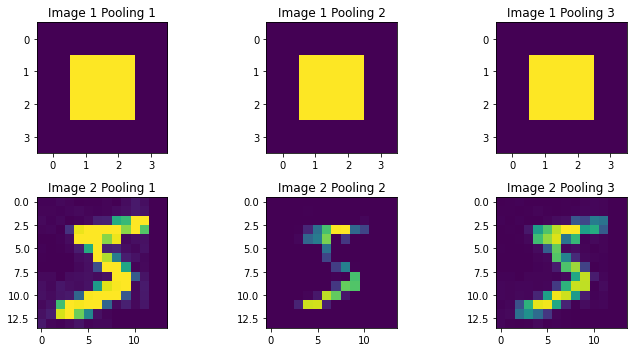

In [48]:
#shows all 3 pooling methods, we exclude global pooling since the output is not a matrix, for some fixed pool size for each image in images
def show_pooling(images, pool_size):
    
    pooledimg = []

    for image in images:
        pooledimg.append(max_pooling(image, pool_size))
        pooledimg.append(min_pooling(image, pool_size))
        pooledimg.append(avg_pooling(image, pool_size))

    _ , axes = plt.subplots(len(images), 3, figsize=(10, 5))
    axes = axes.flatten()

    # Plot the Convoluted Images
    for i in range(len(pooledimg)):
        axes[i].imshow(pooledimg[i])
        axes[i].set_title(f'Image {(i//3)+1} Pooling {(i % 3)+1}')

    # Show the plots
    plt.tight_layout()
    plt.show()

show_pooling(images, 2)

As we can see, when dealing with Classification of Images, Pooling can be very effective to reduce the size of the Image without really loosing the important features.

## Now let's get back to CNN's

### But wait. How do Convolutional Layers actually work? 

A ConvLayer typically takes a Image and tries out many different Kernels, depending on the need the amount of Kernels changes (often 16, 32, 64 etc.), you then get that amount of Images out and plug a Pooling Layer after that to reduce the size of your Tensor without loosing the Features. 

You then learn the best Kernel that best describes your Features. So you essentially have the entries of your Kernel as your weights. 



Now let's start with a Simple CNN to detect handwritten digits using MaxPooling implemented with Keras

In [23]:
# this could be an example for a CNN to classify digits

input_shape = (26,26,1) #greyscale 26x26 images
num_classes = 10 # 10 output classes
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 24, 24, 32)        320       
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 12, 12, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 10, 10, 64)        18496     
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 flatten_17 (Flatten)        (None, 1600)              0         
                                                                 
 dropout_17 (Dropout)        (None, 1600)            

### Implementing Very Deep CNN's using Pytorch

* Inputs are 224x224 images.
* Convolution kernel shape is (3,3) and max pooling window shape is (2,2).
* Number of channels for each convolutional layer 64 -> 128 -> 256 -> 512 -> 512.

In [26]:
class DeepCNN(nn.Module):
    def __init__(self, num_classes=1000):
        super(DeepCNN, self).__init__()

        # Feature extraction layers: Convolutional and pooling layers
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(
                3, 64, kernel_size=3, padding=1
            ),  # 3 input channels, 64 output channels, 3x3 kernel, 1 padding
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2, stride=2
            ),  # Max pooling with 2x2 kernel and stride 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Fully connected layers for classification
        self.classifier = nn.Sequential(
            nn.Linear(
                512 * 7 * 7, 4096
            ),  # 512 channels, 7x7 spatial dimensions after max pooling
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout layer with 0.5 dropout probability
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes),  # Output layer with 'num_classes' output units
        )

    def forward(self, x):
        x = self.feature_extractor(x)  # Pass input through the feature extractor layers
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layers
        x = self.classifier(x)  # Pass flattened output through the classifier layers
        return x

#### Problems of classical CNN's

Deep CNN's are usally very complex, meaning they are very expensive to train and also suffer from the vanishing gradient problem. 

The vanishing gradient Problem occours, if the derivative of the acitvation function is relatively small and thus the gradient propegated to the early nodes will get close to 0, i.e we have litte to no update in the early layers.

#### Solution

A possible solution proposed, was that instead of using Convolutional Layers as fundamental building blocks in our Network, we instead use socalled "Inception" Modules, that combine multiple Convolutions in one Layer. For more details see https://arxiv.org/abs/1409.4842.

A important complete architecture also described in the Paper is GoogleNet, a Pytorch Implementation is given in the following:

In [27]:
class BaseConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BaseConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        return x


class InceptionModule(nn.Module):
    def __init__(self, in_channels, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_proj):
        super(InceptionModule, self).__init__()

        self.b1 = BaseConv2d(in_channels, n1x1, kernel_size=1)

        self.b2 = nn.Sequential(
            BaseConv2d(in_channels, n3x3red, kernel_size=1),
            BaseConv2d(n3x3red, n3x3, kernel_size=3, padding=1),
        )

        self.b3 = nn.Sequential(
            BaseConv2d(in_channels, n5x5red, kernel_size=1),
            BaseConv2d(n5x5red, n5x5, kernel_size=5, padding=2),
        )

        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            BaseConv2d(in_channels, pool_proj, kernel_size=1),
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1, y2, y3, y4], 1)


class AuxiliaryClassifier(nn.Module):
    def __init__(self, in_channels, num_classes, dropout=0.7):
        super(AuxiliaryClassifier, self).__init__()
        self.pool = nn.AvgPool2d(5, stride=3)
        self.conv = BaseConv2d(in_channels, 128, kernel_size=1)
        self.relu = nn.ReLU(True)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(2048, 1024)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class GoogLeNet(nn.Module):
    def __init__(self, use_aux=True):
        super(GoogLeNet, self).__init__()

        self.use_aux = use_aux
        ## block 1
        self.conv1 = BaseConv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.lrn1 = nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75)
        self.maxpool1 = nn.MaxPool2d(3, stride=2, padding=1)

        ## block 2
        self.conv2 = BaseConv2d(64, 64, kernel_size=1)
        self.conv3 = BaseConv2d(64, 192, kernel_size=3, padding=1)
        self.lrn2 = nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75)
        self.maxpool2 = nn.MaxPool2d(3, stride=2, padding=1)

        ## block 3
        self.inception3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, stride=2, padding=1)

        ## block 4
        self.inception4a = InceptionModule(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionModule(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionModule(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionModule(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionModule(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(3, stride=2, padding=1)

        ## block 5
        self.inception5a = InceptionModule(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionModule(832, 384, 192, 384, 48, 128, 128)

        ## auxiliary classifier
        if self.use_aux:
            self.aux1 = AuxiliaryClassifier(512, 1000)
            self.aux2 = AuxiliaryClassifier(528, 1000)

        ## block 6
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, 1000)

    def forward(self, x):
        ## block 1
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.lrn1(x)

        ## block 2
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.lrn2(x)
        x = self.maxpool2(x)

        ## block 3
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)

        ## block 4
        x = self.inception4a(x)
        if self.use_aux:
            aux1 = self.aux1(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        if self.use_aux:
            aux2 = self.aux2(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)

        ## block 5
        x = self.inception5a(x)
        x = self.inception5b(x)

        ## block 6
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)

        if self.use_aux:
            return x, aux1, aux2
        else:
            return x

## Low Latency Inference CNN's using MobileNet


When dealing with tablets or Smartphones, low latency Models that minimize Computational Overhead are needed. Classical CNN's do not really satisfy that, which is why MobileNet was created. 

The Key difference to Classical Convulotional Layers is, that instead of directly applying all weights to all Channels, we first apply a small Kernel to each Layer seperatly and then just use a 1x1 Kernel after that for alle Channels at once. This is typically called a Depthwise Seperable Convolutional Layer.


In [3]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.depthwise = nn.Conv2d(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            groups=in_channels,
        )
        self.pointwise = nn.Conv2d(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0
        )

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x


class MobileNet(nn.Module):
    def __init__(self, num_classes=1000):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)

        # MobileNet body
        self.dw_conv2 = DepthwiseSeparableConv(32, 64, 1)
        self.dw_conv3 = DepthwiseSeparableConv(64, 128, 2)
        self.dw_conv4 = DepthwiseSeparableConv(128, 128, 1)
        self.dw_conv5 = DepthwiseSeparableConv(128, 256, 2)
        self.dw_conv6 = DepthwiseSeparableConv(256, 256, 1)
        self.dw_conv7 = DepthwiseSeparableConv(256, 512, 2)

        # 5 depthwise separable convolutions with stride 1
        self.dw_conv8 = DepthwiseSeparableConv(512, 512, 1)
        self.dw_conv9 = DepthwiseSeparableConv(512, 512, 1)
        self.dw_conv10 = DepthwiseSeparableConv(512, 512, 1)
        self.dw_conv11 = DepthwiseSeparableConv(512, 512, 1)
        self.dw_conv12 = DepthwiseSeparableConv(512, 512, 1)

        self.dw_conv13 = DepthwiseSeparableConv(512, 1024, 2)
        self.dw_conv14 = DepthwiseSeparableConv(1024, 1024, 1)

        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)

        x = self.dw_conv2(x)
        x = F.relu(x)
        x = self.dw_conv3(x)
        x = F.relu(x)
        x = self.dw_conv4(x)
        x = F.relu(x)
        x = self.dw_conv5(x)
        x = F.relu(x)
        x = self.dw_conv6(x)
        x = F.relu(x)
        x = self.dw_conv7(x)
        x = F.relu(x)

        x = self.dw_conv8(x)
        x = F.relu(x)
        x = self.dw_conv9(x)
        x = F.relu(x)
        x = self.dw_conv10(x)
        x = F.relu(x)
        x = self.dw_conv11(x)
        x = F.relu(x)
        x = self.dw_conv12(x)
        x = F.relu(x)

        x = self.dw_conv13(x)
        x = F.relu(x)
        x = self.dw_conv14(x)
        x = F.relu(x)

        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


# Create the model
mobilenet = MobileNet(num_classes=1000)
print(mobilenet)

MobileNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (dw_conv2): DepthwiseSeparableConv(
    (depthwise): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
    (pointwise): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (dw_conv3): DepthwiseSeparableConv(
    (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64)
    (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
  )
  (dw_conv4): DepthwiseSeparableConv(
    (depthwise): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=128)
    (pointwise): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
  )
  (dw_conv5): DepthwiseSeparableConv(
    (depthwise): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=128)
    (pointwise): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (dw_conv6): DepthwiseSeparableConv(
    (depthwise): Conv2d(256, 256, kernel_size=(3, 3)

## Can we just stack more and more Layers to get better Networks?

No, we can't. The Vanishing Gradient Problem can be adressed relatively easy, but adding more Layers generally increases Error due to a degradation problem. 
A way to solve that problem is by introducing socalled residual connections in Residual Neural Networks. They introduce socalled skip-connections such that a Layer can also influence Layers it would normally not touch. See https://arxiv.org/pdf/1512.03385 for more info.

In [ ]:
#todo, implement Resnet?